In [92]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import torch
import copy
import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt
import datetime
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim


In [93]:
## Dataset 1: Bean

##1. K Means clustering
##2. Expectation maximmization
##3. PCA
##4. ICA
##5. Randomized projections

In [94]:
# read data from csv
bean=pd.read_csv("bean.csv")
print(bean.head()) #first 5 rows

    Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
0  28395    610.291       208.178117       173.888747      1.197191   
1  28734    638.018       200.524796       182.734419      1.097356   
2  29380    624.110       212.826130       175.931143      1.209713   
3  30008    645.884       210.557999       182.516516      1.153638   
4  30140    620.134       201.847882       190.279279      1.060798   

   Eccentricity  ConvexArea  EquivDiameter    Extent  Solidity  roundness  \
0      0.549812       28715     190.141097  0.763923  0.988856   0.958027   
1      0.411785       29172     191.272751  0.783968  0.984986   0.887034   
2      0.562727       29690     193.410904  0.778113  0.989559   0.947849   
3      0.498616       30724     195.467062  0.782681  0.976696   0.903936   
4      0.333680       30417     195.896503  0.773098  0.990893   0.984877   

   Compactness  ShapeFactor1  ShapeFactor2  ShapeFactor3  ShapeFactor4  Class  
0     0.913358      0.007332  

In [95]:
bean.isnull().sum()

Area               0
Perimeter          0
MajorAxisLength    0
MinorAxisLength    0
AspectRation       0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Solidity           0
roundness          0
Compactness        0
ShapeFactor1       0
ShapeFactor2       0
ShapeFactor3       0
ShapeFactor4       0
Class              0
dtype: int64

In [96]:
bean = bean.drop(columns = ['Class'], axis = 1)

In [97]:
bean.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272751,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166


In [98]:
# Selecting features for clustering
X = bean

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

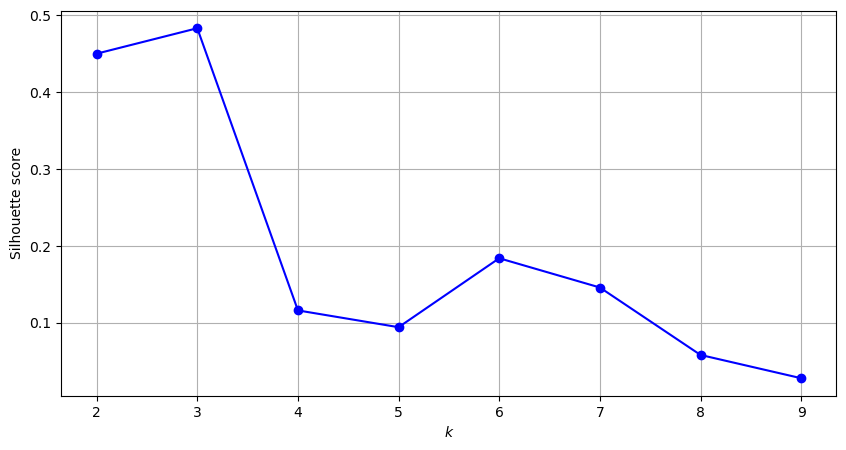

In [87]:
from sklearn.metrics import silhouette_score

Kmeans_cluster = [
    KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_scaled)
    for k in range(2, 10)
]

silhouette_scores = [
    silhouette_score(bean, model.labels_)
    for model in Kmeans_cluster
]

plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.show()

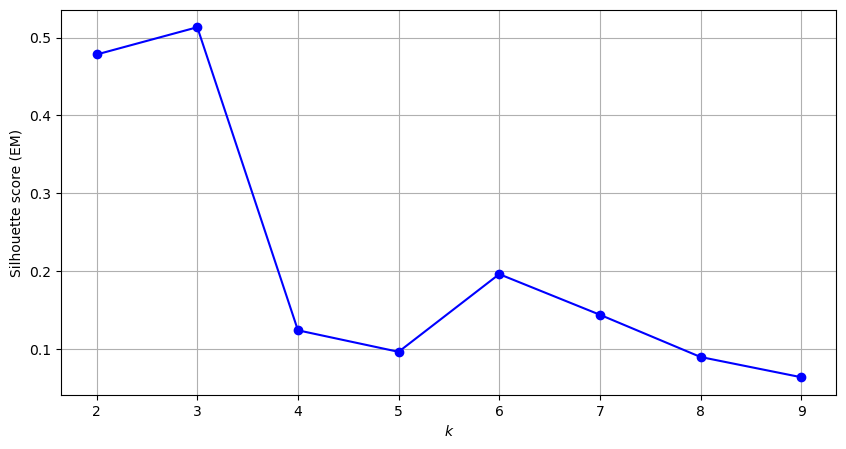

In [12]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
EM_cluster = [
    GaussianMixture(n_components=k, random_state=42).fit(X_scaled)
    for k in range(2, 10)
]

silhouette_scores_EM = [
    silhouette_score(bean, model.predict(X_scaled))
    for model in EM_cluster
]

plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score (EM)")
plt.grid(True)
plt.show()



In [37]:
from sklearn.decomposition import PCA

pca = PCA(random_state = 42, svd_solver = 'full')
pca.fit(X_scaled)
#cumulative sum
cumsum = np.cumsum(pca.explained_variance_ratio_)
dimention = np.argmax(cumsum >= 0.95) + 1

In [38]:
# minimum dimensions required to preserve 95% of the variance
dimention

4

In [39]:
cumsum

array([0.55466439, 0.81897412, 0.89903976, 0.95018056, 0.97757349,
       0.9890711 , 0.99604761, 0.99929843, 0.9998147 , 0.99990557,
       0.99997146, 0.99998983, 0.99999913, 0.99999975, 0.99999989,
       1.        ])

In [40]:
cumsum[4]

0.9775734923298087

In [41]:
cumsum[3]

0.9501805632947681

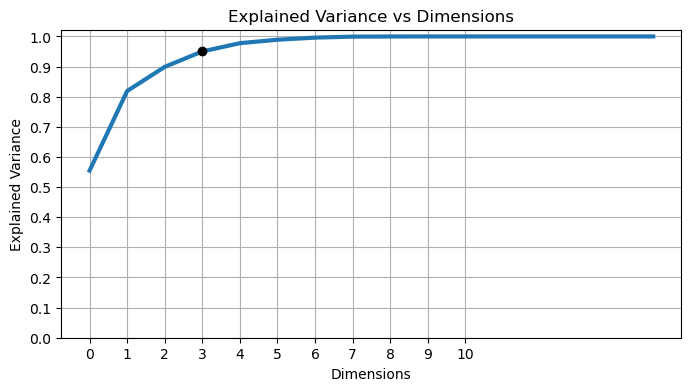

In [42]:
plt.figure(figsize = (8, 4))

plt.plot(cumsum, linewidth=3)

plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.title("Explained Variance vs Dimensions")
plt.plot(3, cumsum[3], "ko")
plt.xticks(np.arange(0, 11, 1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)

plt.show()

In [43]:
# Initiating PCA to reduce features to 3
pca = PCA(n_components = 3, random_state = 42, svd_solver = 'full')
pca.fit(X_scaled)
X_scaled_reduced = pd.DataFrame(pca.transform(X_scaled), columns = (['col1', 'col2', 'col3']))

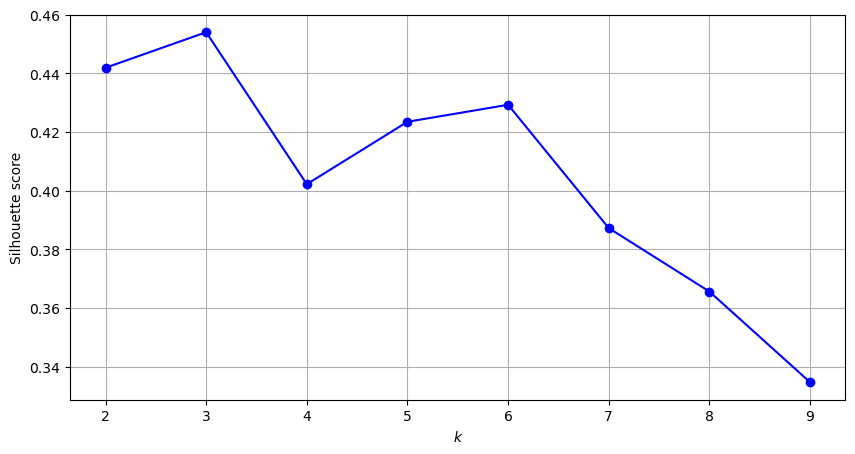

In [44]:
from sklearn.metrics import silhouette_score

Kmeans_cluster = [
    KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_scaled_reduced)
    for k in range(2, 10)
]

silhouette_scores = [
    silhouette_score(X_scaled_reduced, model.labels_)
    for model in Kmeans_cluster
]

plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.show()

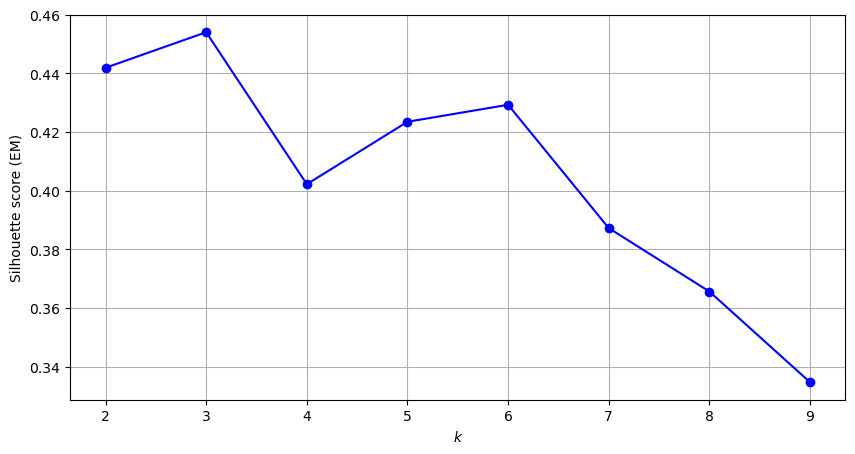

In [45]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
EM_cluster = [
    GaussianMixture(n_components=k, random_state=42).fit(X_scaled_reduced)
    for k in range(2, 10)
]

silhouette_scores_EM = [
    silhouette_score(X_scaled_reduced, model.predict(X_scaled_reduced))
    for model in EM_cluster
]

plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score (EM)")
plt.grid(True)
plt.show()



C:\Users\Edward\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


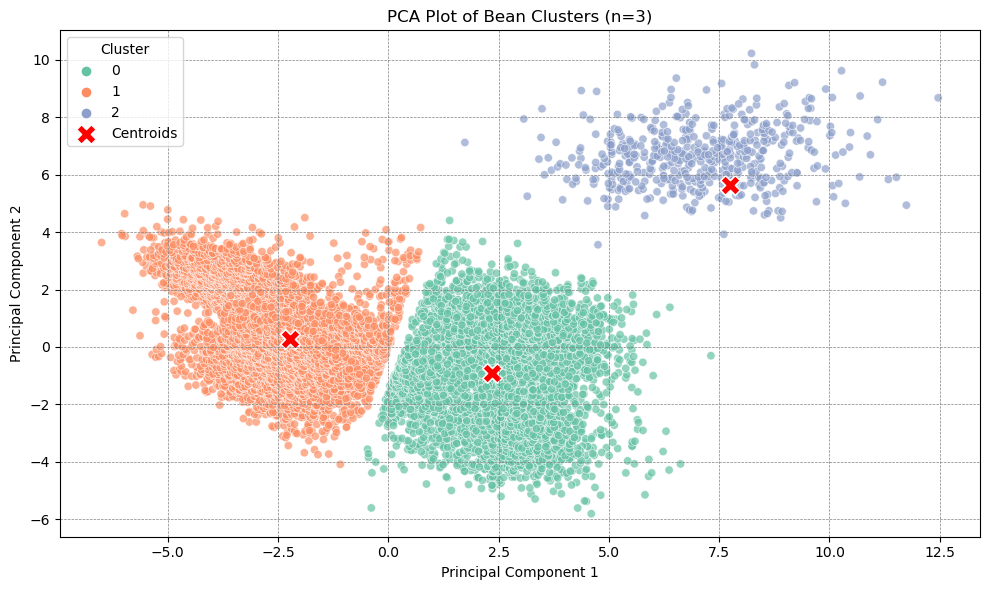

In [89]:
# Cluster Image

kmeans = KMeans(n_clusters= 3, random_state=42)  #change value of n_clusters
cluster_labels = kmeans.fit_predict(X_scaled_reduced)
bean['Cluster'] = cluster_labels
bean.to_excel('Clustered_data1.xlsx', index = False)


df= pd.read_excel('Clustered_data1.xlsx')

scaler = StandardScaler()
normalized_data = scaler.fit_transform(df)

pca = PCA(n_components=2)
pca_data = pca.fit_transform(normalized_data)

df['PC1'] = pca_data[:, 0]
df['PC2'] = pca_data[:, 1]


cluster_palette = sns.color_palette("Set2", n_colors = len(df['Cluster'].unique()))

plt.figure(figsize = (10, 6))

sns.scatterplot(df, x = 'PC1', y = 'PC2', hue = 'Cluster', palette = cluster_palette, alpha = 0.7)

plt.title("PCA Plot of Bean Clusters (n=3)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.grid(True)
plt.tight_layout()


plt.legend(title="Cluster", bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(color='gray', linestyle='--', linewidth=0.5)

sns.scatterplot(x = kmeans.cluster_centers_[:,0], y = kmeans.cluster_centers_[:,1], marker = 'X', s = 200, color = 'red', label = 'Centroids')
plt.legend(title = 'Cluster')


plt.show()

C:\Users\Edward\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


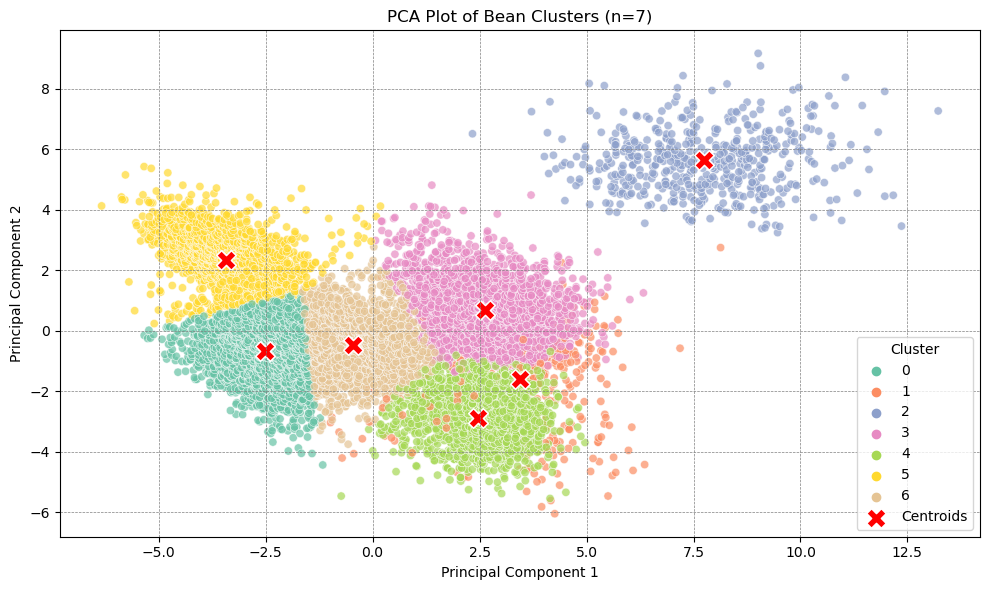

In [90]:
# Cluster Image

kmeans = KMeans(n_clusters= 7, random_state=42)  #change value of n_clusters
cluster_labels = kmeans.fit_predict(X_scaled_reduced)
bean['Cluster'] = cluster_labels
bean.to_excel('Clustered_data1.xlsx', index = False)


df= pd.read_excel('Clustered_data1.xlsx')

scaler = StandardScaler()
normalized_data = scaler.fit_transform(df)

pca = PCA(n_components=2)
pca_data = pca.fit_transform(normalized_data)

df['PC1'] = pca_data[:, 0]
df['PC2'] = pca_data[:, 1]


cluster_palette = sns.color_palette("Set2", n_colors = len(df['Cluster'].unique()))

plt.figure(figsize = (10, 6))

sns.scatterplot(df, x = 'PC1', y = 'PC2', hue = 'Cluster', palette = cluster_palette, alpha = 0.7)

plt.title("PCA Plot of Bean Clusters (n=7)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

plt.grid(True)
plt.tight_layout()


plt.legend(title="Cluster", bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(color='gray', linestyle='--', linewidth=0.5)

sns.scatterplot(x = kmeans.cluster_centers_[:,0], y = kmeans.cluster_centers_[:,1], marker = 'X', s = 200, color = 'red', label = 'Centroids')
plt.legend(title = 'Cluster')


plt.show()

C:\Users\Edward\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\Edward\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


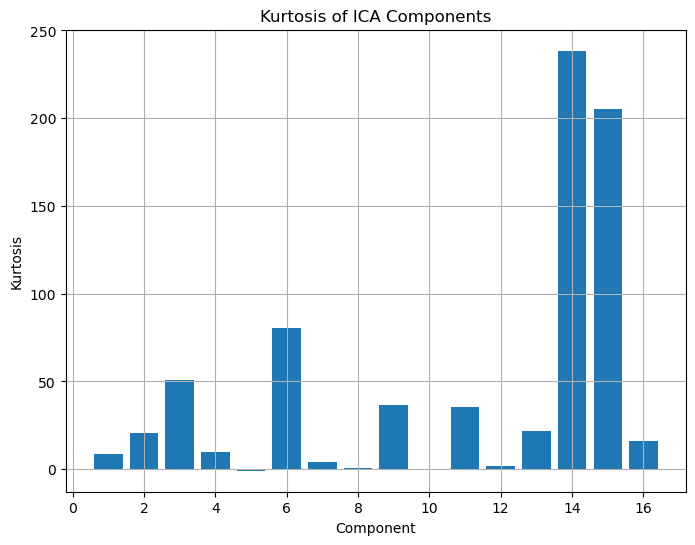

In [99]:
from sklearn.decomposition import FastICA
import scipy.stats as stats
from scipy.stats import kurtosis
# ICA
ica = FastICA(random_state=42)
reduced_data = ica.fit_transform(X_scaled)

# Calculate kurtosis for each component
component_kurtosis = kurtosis(reduced_data, axis=0)

# Plot the kurtosis values
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(component_kurtosis) + 1), component_kurtosis)
plt.xlabel('Component')
plt.ylabel('Kurtosis')
plt.title('Kurtosis of ICA Components')
plt.grid(True)
plt.show()

In [52]:
ica = FastICA(n_components=24, random_state=42)
reduced_data_ica = ica.fit_transform(X_scaled)

C:\Users\Edward\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
C:\Users\Edward\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:589: UserWarning: n_components is too large: it will be set to 16
  warnings.warn(
C:\Users\Edward\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


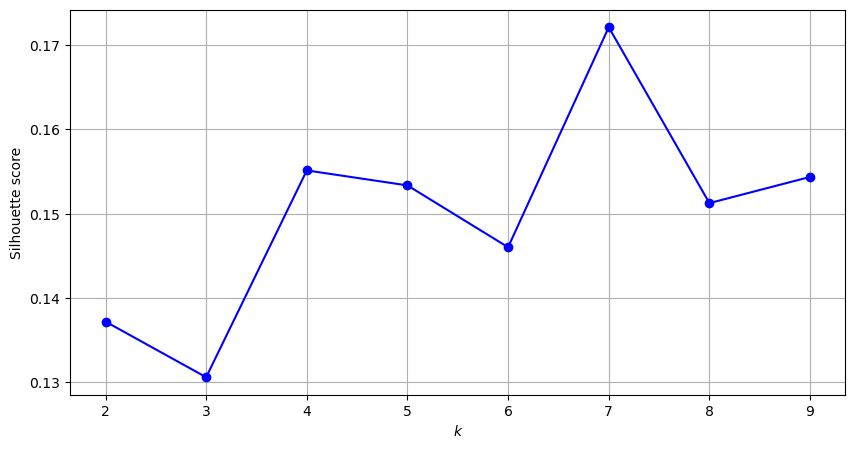

In [75]:
from sklearn.metrics import silhouette_score

Kmeans_cluster = [
    KMeans(n_clusters=k, n_init=10, random_state=42).fit(reduced_data_ica)
    for k in range(2, 10)
]

silhouette_scores = [
    silhouette_score(reduced_data_ica, model.labels_)
    for model in Kmeans_cluster
]

plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.show()

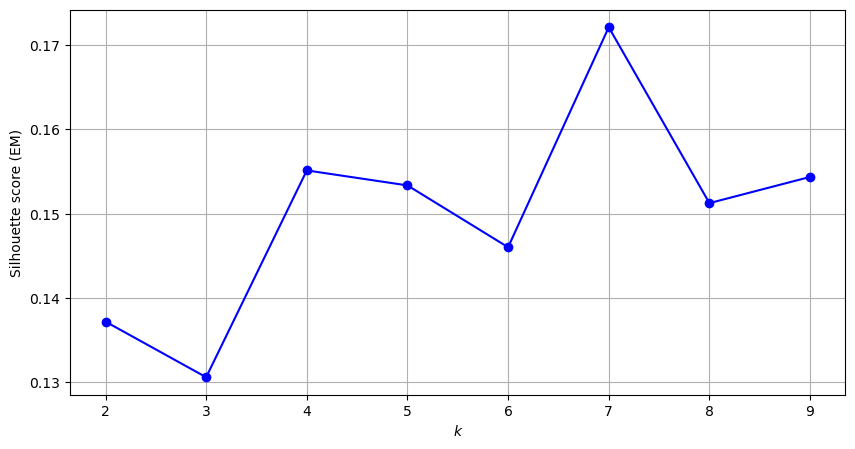

In [54]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
EM_cluster = [
    GaussianMixture(n_components=k, random_state=42).fit(reduced_data_ica)
    for k in range(2, 10)
]

silhouette_scores_EM = [
    silhouette_score(reduced_data_ica, model.predict(reduced_data_ica))
    for model in EM_cluster
]

plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score (EM)")
plt.grid(True)
plt.show()



IndexError: index 2 is out of bounds for axis 0 with size 2

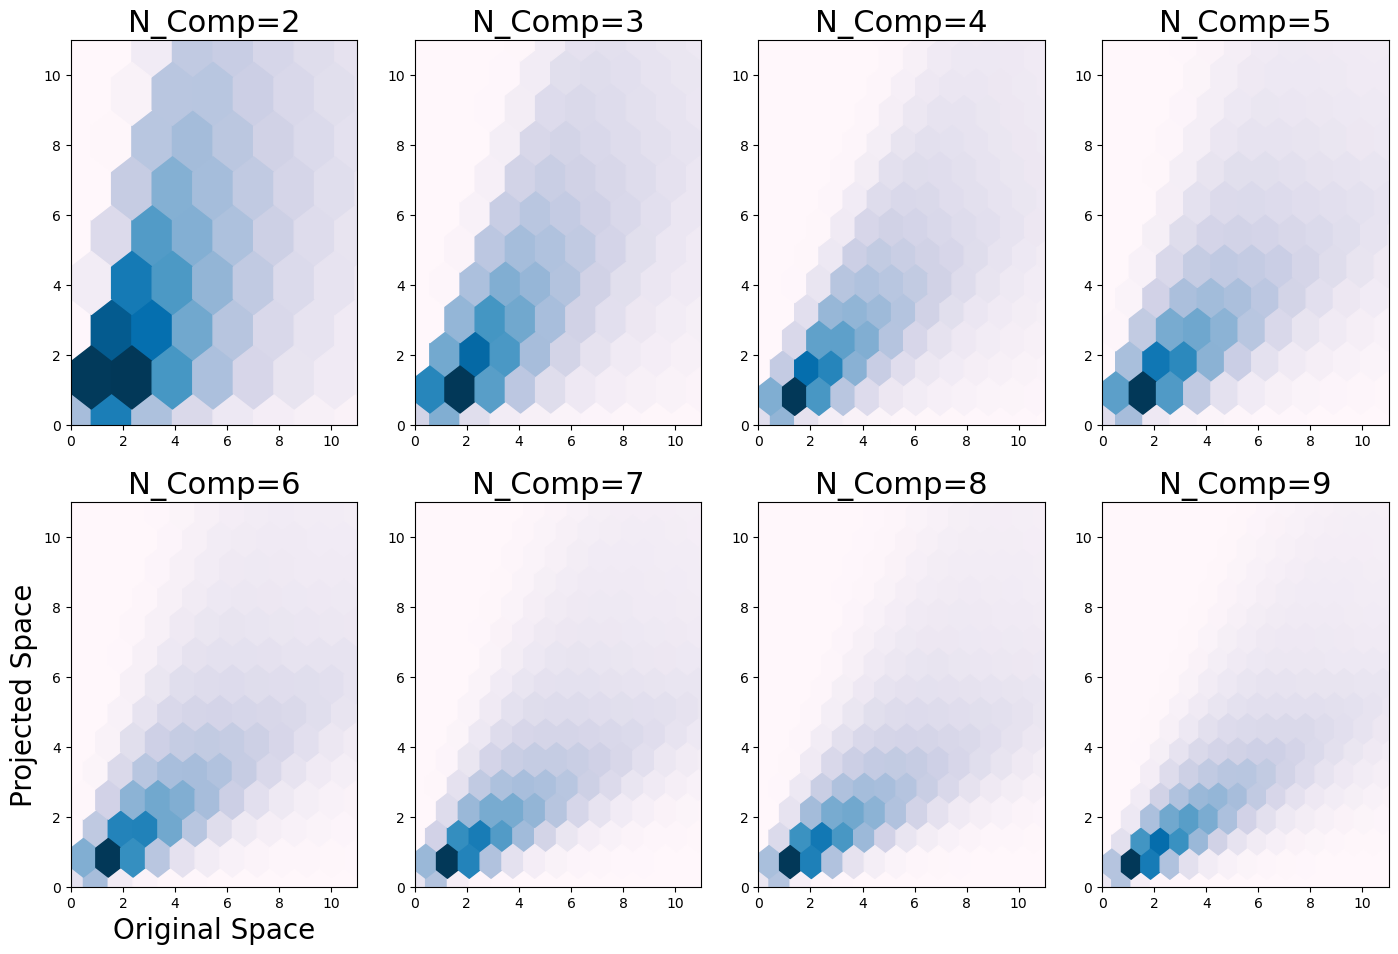

In [100]:

from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics.pairwise import euclidean_distances
# Define the range of dimensions to try
dimensions_range = range(2, 11)  # Adjust the range as needed

# Plot the effect of different dimensions of Gaussian Random Projection
f, ax = plt.subplots(2, 4, figsize=(17, 11))
for i, n_comp in enumerate(dimensions_range):
    transformer = GaussianRandomProjection(n_components=n_comp, random_state=42)
    projected_data = transformer.fit_transform(X_scaled)

    dists = euclidean_distances(X_scaled, squared=True).ravel()
    nonzero = dists != 0
    dists = dists[nonzero]

    projected_dists = euclidean_distances(
        projected_data, squared=True).ravel()[nonzero]

    min_dist = min(projected_dists.min(), dists.min())
    max_dist = max(projected_dists.max(), dists.max())
    ax[i // 4, i % 4].hexbin(dists, projected_dists, gridsize=1000, cmap=plt.cm.PuBu,
                             extent=[min_dist, max_dist, min_dist, max_dist])
    ax[i // 4, i % 4].set_title("N_Comp=%d" % n_comp, fontsize=22)
    ax[1, 0].set_xlabel("Original Space", fontsize=20)
    ax[1, 0].set_ylabel("Projected Space", fontsize=20)
    ax[i // 4, i % 4].set_xlim(0, 11)
    ax[i // 4, i % 4].set_ylim(0, 11)

plt.tight_layout()
plt.show()

In [101]:
transformer = GaussianRandomProjection(n_components=7, random_state=42)
projected_data = transformer.fit_transform(X_scaled)

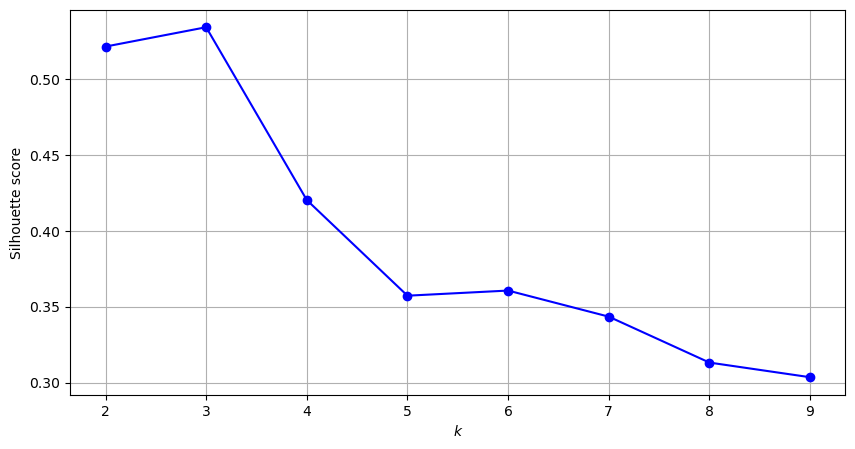

In [102]:
from sklearn.metrics import silhouette_score

Kmeans_cluster = [
    KMeans(n_clusters=k, n_init=10, random_state=42).fit(projected_data)
    for k in range(2, 10)
]

silhouette_scores = [
    silhouette_score(projected_data, model.labels_)
    for model in Kmeans_cluster
]

plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.show()

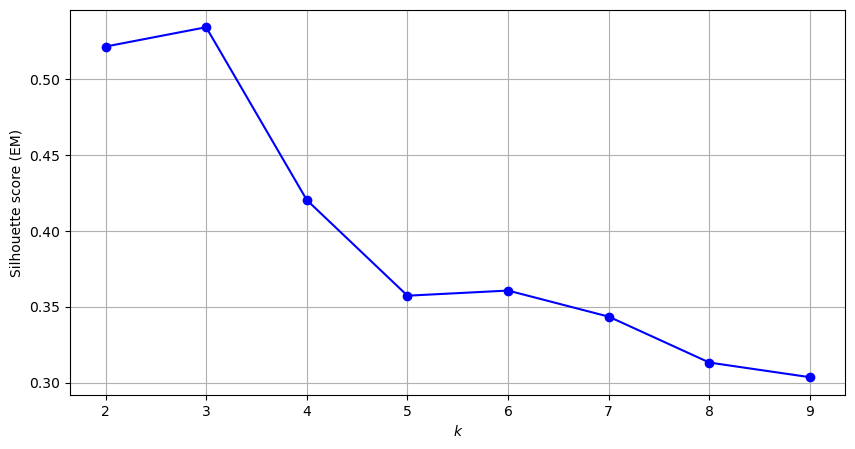

In [103]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
EM_cluster = [
    GaussianMixture(n_components=k, random_state=42).fit(projected_data)
    for k in range(2, 10)
]

silhouette_scores_EM = [
    silhouette_score(projected_data, model.predict(projected_data))
    for model in EM_cluster
]

plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score (EM)")
plt.grid(True)
plt.show()



In [68]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
#Random forest 
X = bean.values[:,:-2]
y = bean.values[:,-1]

X_train1_b, X_test1_b, y_train1_b, y_test1_b = train_test_split(X, y, test_size=0.2, random_state=42)
X_train1, X_test1, y_train1, y_test1 = X_train1_b, X_test1_b, y_train1_b, y_test1_b
y_train1_b.sum(), y_test1_b.sum()

scaler = StandardScaler()
scaler.fit(X_train1_b)
scaler.mean_
X_train1 = scaler.transform(X_train1_b)
print("Train: ", X_train1.shape, "Positive examples: ", y_train1.sum())

X_test1 = scaler.transform(X_test1_b)
print("Test: ", X_test1.shape, "Positive examples: ", y_test1.sum())

df1 = df.copy()
print(df.columns)


model = RandomForestClassifier(n_estimators=100, max_depth=3)
model.fit(X_train1, y_train1)
importance = model.feature_importances_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

importance = sorted(importance)
print(importance)
# Feature exclude 8,9,10 ('EquivDiameter', 'Extent','Solidity')
mask_d1 = np.array(importance)>0.05
print(mask_d1)


Train:  (10888, 15) Positive examples:  35395.0
Test:  (2723, 15) Positive examples:  8978.0
Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4', 'Cluster', 'PC1', 'PC2'],
      dtype='object')
Feature: 0, Score: 0.06273
Feature: 1, Score: 0.08171
Feature: 2, Score: 0.13729
Feature: 3, Score: 0.08257
Feature: 4, Score: 0.05285
Feature: 5, Score: 0.09948
Feature: 6, Score: 0.06632
Feature: 7, Score: 0.05241
Feature: 8, Score: 0.00034
Feature: 9, Score: 0.00181
Feature: 10, Score: 0.02024
Feature: 11, Score: 0.08809
Feature: 12, Score: 0.06491
Feature: 13, Score: 0.10491
Feature: 14, Score: 0.08432
[0.0003365706991371263, 0.0018137716841116688, 0.020244335954662934, 0.05241124418494831, 0.05285426735737102, 0.06273059780406384, 0.06491002454978256, 0.06631912494723474, 0.081714380

In [104]:
bean1=pd.read_csv("bean.csv")
DF_RF=bean1.drop(columns = ['EquivDiameter','Extent','Solidity','Class'], axis = 1)
# Selecting features for clustering
X1 = DF_RF

# Standardize the features
scaler = StandardScaler()
X_scaled1 = scaler.fit_transform(X1)


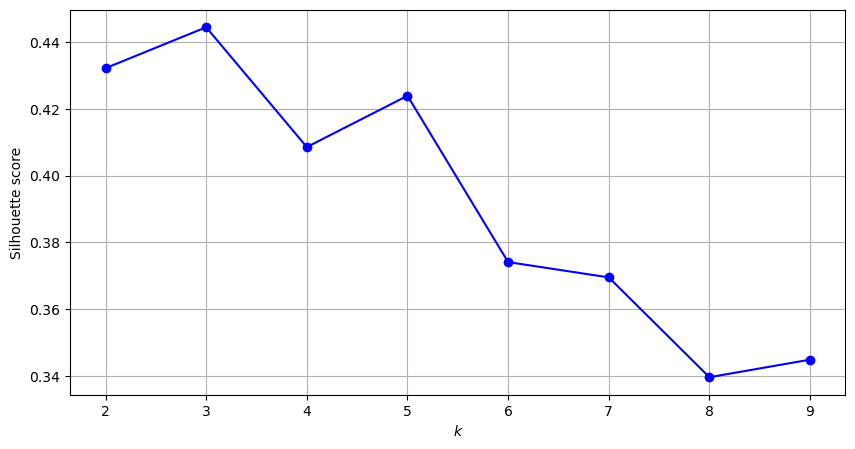

In [105]:
from sklearn.metrics import silhouette_score

Kmeans_cluster = [
    KMeans(n_clusters=k, n_init=10, random_state=42).fit(X_scaled1)
    for k in range(2, 10)
]

silhouette_scores = [
    silhouette_score(X_scaled1, model.labels_)
    for model in Kmeans_cluster
]

plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.show()

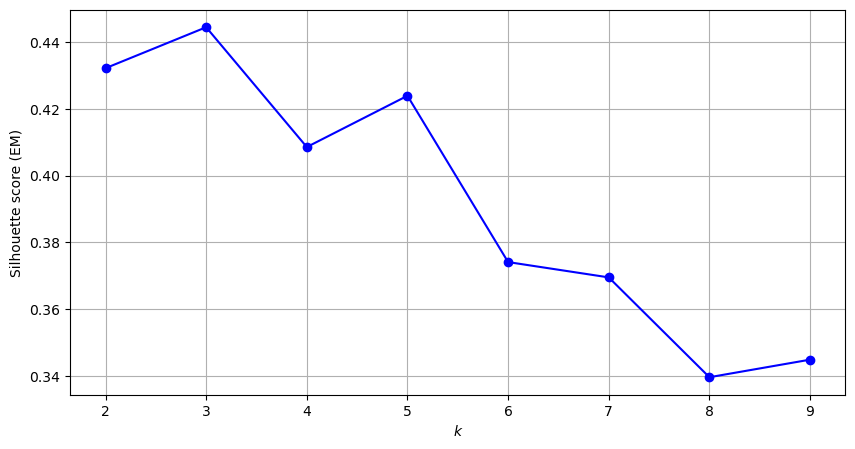

In [106]:
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
EM_cluster = [
    GaussianMixture(n_components=k, random_state=42).fit(X_scaled1)
    for k in range(2, 10)
]

silhouette_scores_EM = [
    silhouette_score(X_scaled1, model.predict(X_scaled1))
    for model in EM_cluster
]

plt.figure(figsize=(10, 5))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score (EM)")
plt.grid(True)
plt.show()

